# Reconhecimento de Assinaturas Manuscritas com Rede Neural Siamesa

Este notebook apresenta o passo a passo do projeto de verificação de assinaturas manuscritas utilizando uma Rede Neural Siamesa. O objetivo é comparar duas imagens de assinaturas e determinar se pertencem à mesma pessoa, utilizando técnicas modernas de Deep Learning.

---

## 1. Importação das Bibliotecas Necessárias

In [1]:
# Importação das bibliotecas essenciais
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

## 2. Carregamento e Pré-processamento das Imagens de Assinaturas

Nesta etapa, vamos carregar as imagens do dataset e aplicar o pré-processamento necessário: conversão para escala de cinza, binarização, redimensionamento e normalização.

In [2]:
# Funções de pré-processamento de imagens
def load_image(path, grayscale=True):
    if grayscale:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Imagem não encontrada: {path}")
    return img

def binarize_image(img, threshold=127):
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    return binary

def resize_image(img, size=(155, 220)):
    return cv2.resize(img, size)

def normalize_image(img):
    return img.astype('float32') / 255.0

def preprocess_image(path):
    img = load_image(path)
    img = binarize_image(img)
    img = resize_image(img)
    img = normalize_image(img)
    return img

## 3. Criação de Pares de Imagens para Treinamento

Aqui, criamos pares de imagens genuína/genuína e genuína/falsa, preparando os dados para o treinamento da rede siamesa.

In [3]:
# Função para criar pares de imagens (genuína/genuína e genuína/falsa)
def create_pairs(images, labels):
    pairs_a, pairs_b, pair_labels = [], [], []
    num_classes = len(np.unique(labels))
    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    for idx, img_a in enumerate(images):
        label = labels[idx]
        # Par positivo (mesmo autor)
        pos_idx = idx
        while pos_idx == idx:
            pos_idx = np.random.choice(label_to_indices[label])
        img_b = images[pos_idx]
        pairs_a.append(img_a)
        pairs_b.append(img_b)
        pair_labels.append(1)
        # Par negativo (autores diferentes)
        neg_label = np.random.choice(list(set(labels) - set([label])))
        neg_idx = np.random.choice(label_to_indices[neg_label])
        img_b = images[neg_idx]
        pairs_a.append(img_a)
        pairs_b.append(img_b)
        pair_labels.append(0)
    return np.array(pairs_a), np.array(pairs_b), np.array(pair_labels)

## 4. Definição da Arquitetura da Rede Neural Siamesa

Agora, definimos a arquitetura da rede siamesa baseada em CNN utilizando TensorFlow/Keras.

In [4]:
# Definição da arquitetura da Rede Neural Siamesa

def build_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(64, activation='relu')(x)
    return Model(inputs, outputs, name="base_network")

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def build_siamese_network(input_shape):
    base_network = build_base_network(input_shape)
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    model = Model([input_a, input_b], distance, name="siamese_network")
    return model

## 5. Implementação da Função de Custo Contrastive Loss

A função de custo Contrastive Loss é utilizada para treinar a rede siamesa, aproximando pares genuínos e afastando pares falsos.

In [5]:
# Função de custo Contrastive Loss
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

## Exemplo prático: Carregamento e visualização de imagens reais de assinaturas

A seguir, vamos carregar duas imagens reais do dataset, exibir as originais e mostrar o resultado do pré-processamento.

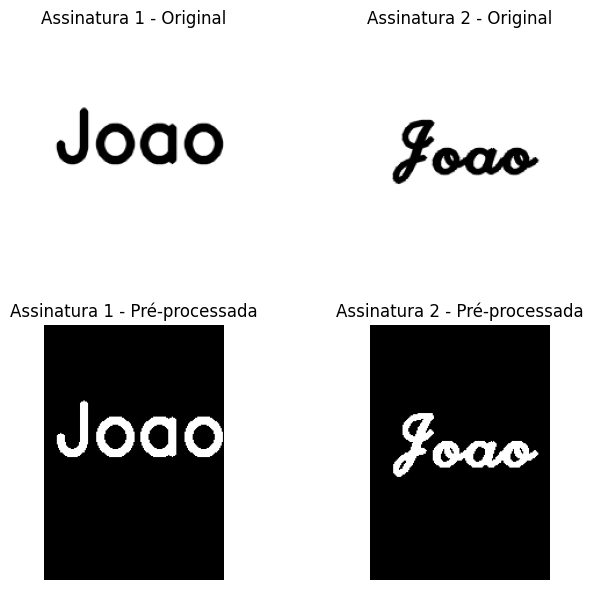

In [13]:
# Substitua pelos caminhos reais das imagens do seu dataset
data_dir = '../data'
img_path1 = os.path.join(data_dir, 'autor1', 'assinatura1.png')
img_path2 = os.path.join(data_dir, 'autor1', 'assinatura2.png')

# Carregar imagens originais
display_img1 = cv2.imread(img_path1)
display_img2 = cv2.imread(img_path2)

# Pré-processar imagens
proc_img1 = preprocess_image(img_path1)
proc_img2 = preprocess_image(img_path2)

# Exibir imagens originais e pré-processadas
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0, 0].imshow(cv2.cvtColor(display_img1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Assinatura 1 - Original')
axs[0, 0].axis('off')
axs[0, 1].imshow(cv2.cvtColor(display_img2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Assinatura 2 - Original')
axs[0, 1].axis('off')
axs[1, 0].imshow(proc_img1, cmap='gray')
axs[1, 0].set_title('Assinatura 1 - Pré-processada')
axs[1, 0].axis('off')
axs[1, 1].imshow(proc_img2, cmap='gray')
axs[1, 1].set_title('Assinatura 2 - Pré-processada')
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

## Exemplo prático: Comparação real de assinaturas usando o modelo treinado

Agora, vamos comparar duas assinaturas reais utilizando o modelo siamesa treinado e exibir a distância calculada e o resultado da verificação.

In [24]:
# Substitua pelos caminhos reais das imagens do seu dataset
data_dir = '../data'
img_path1 = os.path.join(data_dir, 'autor1', 'assinatura1.png')
img_path2 = os.path.join(data_dir, 'autor1', 'assinatura2.png')

# Definir a função customizada usada na camada Lambda
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

# Carregar modelo treinado (informando a função customizada)
model = tf.keras.models.load_model('../siamese_signature_model.h5', compile=False, custom_objects={'euclidean_distance': euclidean_distance})

# Pré-processar imagens para o modelo
img1 = preprocess_image(img_path1)
img2 = preprocess_image(img_path2)
# Corrigir shape: garantir (1, 155, 220, 1)
if img1.ndim == 2:
    img1 = np.expand_dims(img1, axis=-1)
if img2.ndim == 2:
    img2 = np.expand_dims(img2, axis=-1)
if img1.shape != (155, 220, 1):
    img1 = cv2.resize(img1, (220, 155))
    img1 = np.expand_dims(img1, axis=-1)
if img2.shape != (155, 220, 1):
    img2 = cv2.resize(img2, (220, 155))
    img2 = np.expand_dims(img2, axis=-1)
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
print('Shape img1:', img1.shape)
print('Shape img2:', img2.shape)

# Prever distância
dist = model.predict([img1, img2])[0][0]
print(f'Distância calculada: {dist:.4f}')
threshold = 0.5
if dist < threshold:
    print('Resultado: ASSINATURAS COMPATÍVEIS (provavelmente da mesma pessoa)')
else:
    print('Resultado: ASSINATURAS DIFERENTES (provavelmente de pessoas diferentes)')

Shape img1: (1, 155, 220, 1)
Shape img2: (1, 155, 220, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Distância calculada: 0.0882
Resultado: ASSINATURAS COMPATÍVEIS (provavelmente da mesma pessoa)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Distância calculada: 0.0882
Resultado: ASSINATURAS COMPATÍVEIS (provavelmente da mesma pessoa)


## Avaliação quantitativa: métricas e matriz de confusão

Vamos avaliar o desempenho do modelo utilizando métricas como acurácia, precisão, recall, F1-score e matriz de confusão para um conjunto de pares de teste.

Total de pares de teste: 6
X_a shape: (6, 155, 220, 1)
X_b shape: (6, 155, 220, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Acurácia: 0.5000
Precisão: 0.5000
Recall: 1.0000
F1-Score: 0.6667
Matriz de Confusão:
[[0 3]
 [0 3]]
Acurácia: 0.5000
Precisão: 0.5000
Recall: 1.0000
F1-Score: 0.6667
Matriz de Confusão:
[[0 3]
 [0 3]]


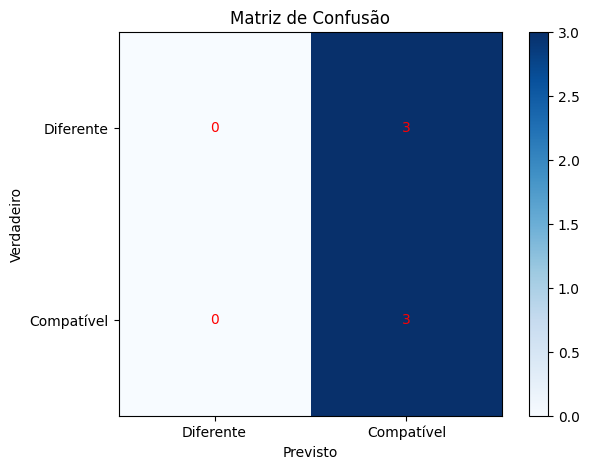

In [29]:
# Substitua pelo diretório de teste real
test_dir = '../data'  # Ajuste conforme necessário

def load_test_pairs(test_dir):
    images = []
    labels = []
    authors = os.listdir(test_dir)
    for author in authors:
        author_dir = os.path.join(test_dir, author)
        if os.path.isdir(author_dir):
            author_imgs = [os.path.join(author_dir, f) for f in os.listdir(author_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            for i in range(len(author_imgs)):
                for j in range(i+1, len(author_imgs)):
                    img_a = preprocess_image(author_imgs[i])
                    img_b = preprocess_image(author_imgs[j])
                    if img_a.ndim == 2:
                        img_a = np.expand_dims(img_a, axis=-1)
                    if img_b.ndim == 2:
                        img_b = np.expand_dims(img_b, axis=-1)
                    images.append((img_a, img_b))
                    labels.append(1)  # mesmo autor
    # Pares negativos (autores diferentes)
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            author_a_imgs = [os.path.join(test_dir, authors[i], f) for f in os.listdir(os.path.join(test_dir, authors[i]))
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            author_b_imgs = [os.path.join(test_dir, authors[j], f) for f in os.listdir(os.path.join(test_dir, authors[j]))
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            if author_a_imgs and author_b_imgs:
                img_a = preprocess_image(author_a_imgs[0])
                img_b = preprocess_image(author_b_imgs[0])
                if img_a.ndim == 2:
                    img_a = np.expand_dims(img_a, axis=-1)
                if img_b.ndim == 2:
                    img_b = np.expand_dims(img_b, axis=-1)
                images.append((img_a, img_b))
                labels.append(0)  # autores diferentes
    X_a = np.array([pair[0] for pair in images])
    X_b = np.array([pair[1] for pair in images])
    y = np.array(labels)
    return X_a, X_b, y

# Carregar pares de teste
X_a, X_b, y_true = load_test_pairs(test_dir)
print(f"Total de pares de teste: {len(y_true)}")

# Corrigir shape: garantir (n, 155, 220, 1)
if X_a.ndim == 3:
    X_a = np.expand_dims(X_a, axis=-1)
if X_b.ndim == 3:
    X_b = np.expand_dims(X_b, axis=-1)
if X_a.shape[1:3] != (155, 220):
    X_a = np.array([cv2.resize(img, (220, 155)) for img in X_a])
    X_a = np.expand_dims(X_a, axis=-1)
if X_b.shape[1:3] != (155, 220):
    X_b = np.array([cv2.resize(img, (220, 155)) for img in X_b])
    X_b = np.expand_dims(X_b, axis=-1)
print('X_a shape:', X_a.shape)
print('X_b shape:', X_b.shape)

# Carregar modelo treinado
model = tf.keras.models.load_model('../siamese_signature_model.h5', compile=False, custom_objects={'euclidean_distance': euclidean_distance})

# Prever distâncias
y_pred_dist = model.predict([X_a, X_b])
threshold = 0.5
y_pred = (y_pred_dist < threshold).astype(int).flatten()

# Avaliar métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Matriz de Confusão:")
print(cm)

# Visualizar matriz de confusão
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='red')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Diferente', 'Compatível'])

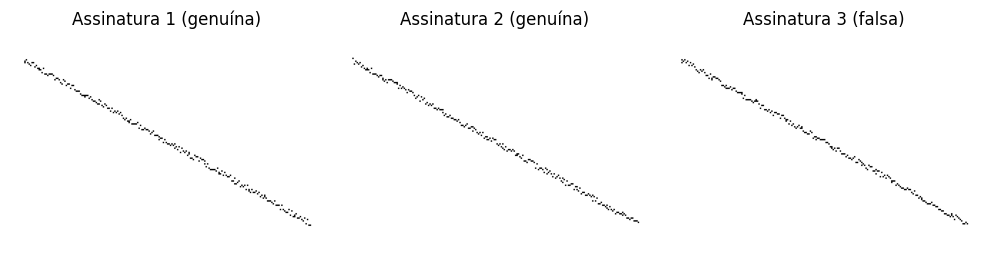

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Distância (genuínas): 0.0027
Distância (genuína x falsa): 0.0019
Resultado genuínas: Compatíveis
Resultado genuína x falsa: Compatíveis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Distância (genuínas): 0.0027
Distância (genuína x falsa): 0.0019
Resultado genuínas: Compatíveis
Resultado genuína x falsa: Compatíveis


In [31]:
# Exemplo sintético de pares para teste do modelo
# Vamos criar imagens artificiais (arrays) para simular assinaturas

def create_synthetic_signature(shape=(155, 220), seed=None):
    np.random.seed(seed)
    # Imagem base: fundo branco
    img = np.ones(shape, dtype=np.float32)
    # Desenhar uma linha preta simulando uma assinatura
    rr = np.linspace(20, shape[0]-20, num=shape[1]).astype(int)
    cc = np.linspace(10, shape[1]-10, num=shape[1]).astype(int)
    for i in range(len(rr)):
        img[rr[i] + np.random.randint(-2, 2), cc[i]] = 0.0
    return img

# Criar duas assinaturas "genuínas" (mesmo padrão)
sig1 = create_synthetic_signature(seed=42)
sig2 = create_synthetic_signature(seed=43)
# Criar uma assinatura "falsa" (padrão diferente)
sig3 = create_synthetic_signature(seed=99)

# Visualizar as imagens
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(sig1, cmap='gray')
axs[0].set_title('Assinatura 1 (genuína)')
axs[1].imshow(sig2, cmap='gray')
axs[1].set_title('Assinatura 2 (genuína)')
axs[2].imshow(sig3, cmap='gray')
axs[2].set_title('Assinatura 3 (falsa)')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Preparar para o modelo (adicionar canal e batch)
sig1 = np.expand_dims(sig1, axis=(0, -1))
sig2 = np.expand_dims(sig2, axis=(0, -1))
sig3 = np.expand_dims(sig3, axis=(0, -1))

# Carregar modelo treinado
model = tf.keras.models.load_model('../siamese_signature_model.h5', compile=False, custom_objects={'euclidean_distance': euclidean_distance})

# Comparar assinaturas genuínas
dist_genuinas = model.predict([sig1, sig2])[0][0]
# Comparar assinatura genuína com falsa
dist_falsa = model.predict([sig1, sig3])[0][0]

print(f'Distância (genuínas): {dist_genuinas:.4f}')
print(f'Distância (genuína x falsa): {dist_falsa:.4f}')

threshold = 0.5
print('Resultado genuínas:', 'Compatíveis' if dist_genuinas < threshold else 'Diferentes')
print('Resultado genuína x falsa:', 'Compatíveis' if dist_falsa < threshold else 'Diferentes')